# Forecast Taxa Selic

Estudo focado em entender a taxa Selic no Brasil e prevê-la nos próximos períodos. Além disso, será útil entender também qual a influência desta taxa nos investimentos de renda fixa.

## 0.0. Imports

In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import os

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time

import matplotlib.pyplot as plt
import seaborn as sns

## 1.0. Coletando Dados

In [2]:
# obtendo path do driver do chrome
driver_path = os.environ.get('CHROME_DRIVER')

# colocando opcao para nao abrir o browser
options = webdriver.ChromeOptions()
options.add_argument('headless')

# instanciando driver
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()), options = options)

In [3]:
# obtendo html da tabela
url_selic = 'https://www.bcb.gov.br/controleinflacao/historicotaxasjuros'
driver.get(url_selic)
time.sleep(1)
html = driver.page_source
table = driver.find_element(By.CLASS_NAME, "table")
table_html = table.get_attribute('outerHTML')

In [4]:
# transformando html em dataframe
df_raw = pd.read_html(table_html)[0]
df_raw.columns = ['reuniao', 'data', 'vies', 'periodo_vigencia', 'meta_selic_aa', 'tban_am', 'taxa_selic', 'taxa_selic_aa']
df_raw.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa
0,248º,03/08/2022,NaN,04/08/2022 -,1375,NaN,NaN,NaN
1,247º,15/06/2022,NaN,17/06/2022 - 03/08/2022,1325,NaN,168.0,1315.0
2,246º,04/05/2022,NaN,05/05/2022 - 16/06/2022,1275,NaN,143.0,1265.0
3,245º,16/03/2022,NaN,17/03/2022 - 04/05/2022,1175,NaN,145.0,1165.0
4,244º,02/02/2022,NaN,03/02/2022 - 16/03/2022,1075,NaN,113.0,1065.0


## 2.0. Limpando e Manipulando Dados

### 2.1. Arrumando numéricos

**taxa_selic**, **meta_selic** e **taxa_selic_aa**: como o separador de decimal estava como vírgula, dividir valores por 100.

In [16]:
df2 = df_raw.copy()

In [17]:
df2['meta_selic_aa'] = df2['meta_selic_aa'] / 100
df2['taxa_selic'] = df2['taxa_selic'] / 100
df2['taxa_selic_aa'] = df2['taxa_selic_aa'] / 100
df2.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa
0,248º,03/08/2022,NaN,04/08/2022 -,13.75,NaN,NaN,NaN
1,247º,15/06/2022,NaN,17/06/2022 - 03/08/2022,13.25,NaN,1.68,13.15
2,246º,04/05/2022,NaN,05/05/2022 - 16/06/2022,12.75,NaN,1.43,12.65
3,245º,16/03/2022,NaN,17/03/2022 - 04/05/2022,11.75,NaN,1.45,11.65
4,244º,02/02/2022,NaN,03/02/2022 - 16/03/2022,10.75,NaN,1.13,10.65


### 2.2. Transformando em granularidade diária

In [18]:
df2['data'] = pd.to_datetime(df2['data'], format = "%d/%m/%Y")
df2['periodo_vigencia_min'] = pd.to_datetime(df2['periodo_vigencia'].apply(lambda x: x[:10]), format = "%d/%m/%Y")
df2['periodo_vigencia_max'] = pd.to_datetime(df2['periodo_vigencia'].apply(lambda x: x[-10:] if len(x) == 23 else np.nan), format = "%d/%m/%Y")
df2.head()

,reuniao,data,vies,periodo_vigencia,meta_selic_aa,tban_am,taxa_selic,taxa_selic_aa,periodo_vigencia_min,periodo_vigencia_max
0,248º,2022-08-03,NaN,04/08/2022 -,13.75,NaN,NaN,NaN,2022-08-04,NaT
1,247º,2022-06-15,NaN,17/06/2022 - 03/08/2022,13.25,NaN,1.68,13.15,2022-06-17,2022-08-03
2,246º,2022-05-04,NaN,05/05/2022 - 16/06/2022,12.75,NaN,1.43,12.65,2022-05-05,2022-06-16
3,245º,2022-03-16,NaN,17/03/2022 - 04/05/2022,11.75,NaN,1.45,11.65,2022-03-17,2022-05-04
4,244º,2022-02-02,NaN,03/02/2022 - 16/03/2022,10.75,NaN,1.13,10.65,2022-02-03,2022-03-16


In [19]:
df2_daily = pd.DataFrame(columns = ['data', 'selic'])

for index, row in df2.sort_values(by = 'data').iterrows():
    # definindo dia mínimo e máximo (se máximo for nulo, colocar data de hoje)
    min_date = row['periodo_vigencia_min']
    max_date = row['periodo_vigencia_max'] if not pd.isnull(row['periodo_vigencia_max']) else pd.Timestamp.today()
    
    df_append = pd.DataFrame({'data': pd.date_range(min_date, max_date, freq='D')})
    df_append['selic'] = row['meta_selic_aa']
    df2_daily = pd.concat([df2_daily, df_append])

df2_daily['ano'] = df2_daily['data'].dt.year
df2_daily['mes'] = df2_daily['data'].dt.month
df2_daily.head()

,data,selic,ano,mes
0,1996-07-01,1.9,1996,7
1,1996-07-02,1.9,1996,7
2,1996-07-03,1.9,1996,7
3,1996-07-04,1.9,1996,7
4,1996-07-05,1.9,1996,7


### 2.3. Limpeza de dados

Visto que as taxas de juros só começaram a ser fixadas na expressão anual a partir de 02/01/1998, dados antes desta data serão ignorados.

In [20]:
df2_daily.shape

(9558, 4)

In [21]:
df2_daily = df2_daily.query('data >= "1998-01-02"')

In [22]:
df2_daily.shape

(8979, 4)

### 2.4. Transformando em granularidade mensal

Para obter a taxa Selic mensal, transforma-se a base em granularidade diária e então calcula-se a média ponderada no mês da taxa.

In [23]:
# calculando média ponderada
aux = df2_daily.groupby(['ano', 'mes', 'selic']).count().reset_index()
wm = lambda x: np.average(x, weights = aux.loc[x.index, "data"])
df2_monthly = aux.groupby(['ano', 'mes']).agg({'selic': wm}).reset_index()
df2_monthly['data'] = pd.to_datetime(df2_monthly['ano'].astype(str) + '-' + df2_monthly['mes'].astype(str), format = "%Y-%m")
df2_monthly

,ano,mes,selic,data
0,1998,1,37.650000,1998-01-01
1,1998,2,34.500000,1998-02-01
2,1998,3,28.838710,1998-03-01
3,1998,4,25.625000,1998-04-01
4,1998,5,22.717742,1998-05-01
...,...,...,...,...
291,2022,4,11.750000,2022-04-01
292,2022,5,12.620968,2022-05-01
293,2022,6,12.983333,2022-06-01
294,2022,7,13.250000,2022-07-01


## 3.0. Feature Engineering

In [28]:
df3 = df2_monthly.copy()

In [60]:
# eleicao
years_eleicao = np.arange(1994, pd.Timestamp.today().year + 1, 4)
df3.loc[df3['ano'].isin(years_eleicao), 'eleicao'] = 1
df3['eleicao'] = df3['eleicao'].fillna(0)

## 4.0. EDA

In [62]:
df4 = df3.copy()

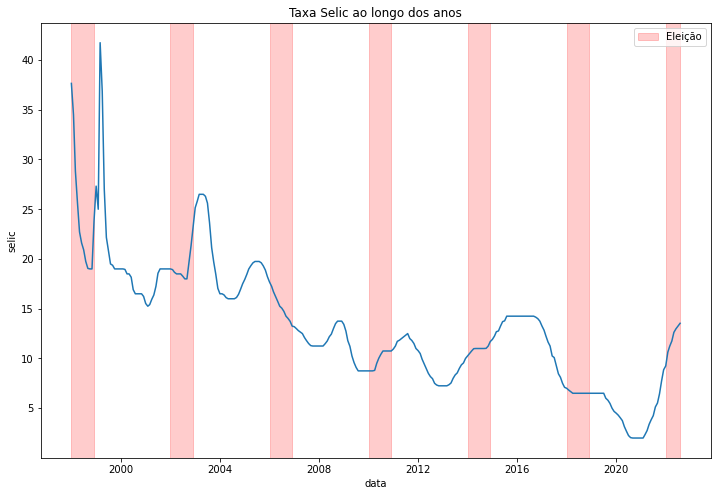

In [68]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(data = df3, x = 'data', y = 'selic', ax = ax);
max_min_date_year = df4.query("eleicao == 1").groupby('ano')['data'].agg(['min', 'max'])

for index, row in max_min_date_year.iterrows():
    if index == 1998:
        ax.axvspan(row['min'], row['max'], alpha=0.2, color='red', label = 'Eleição')
    else:
        ax.axvspan(row['min'], row['max'], alpha=0.2, color='red')

ax.set_title('Taxa Selic ao longo dos anos');
plt.legend();